In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =300

ng =3

nref =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 3 /) 

data wgt
     &     /0.5 , 0.55 , 0.85/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.8/

klin =1e-24

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

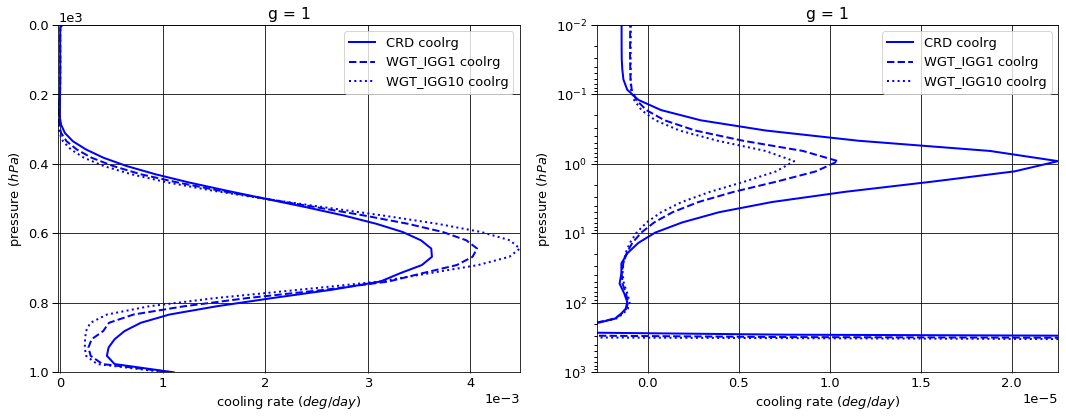

# Figure: cooling rate g-group 2

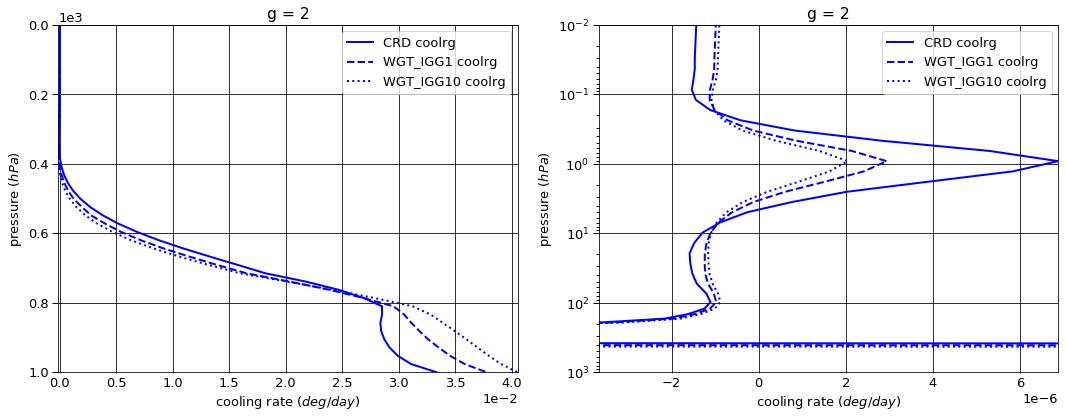

# Figure: cooling rate g-group 3

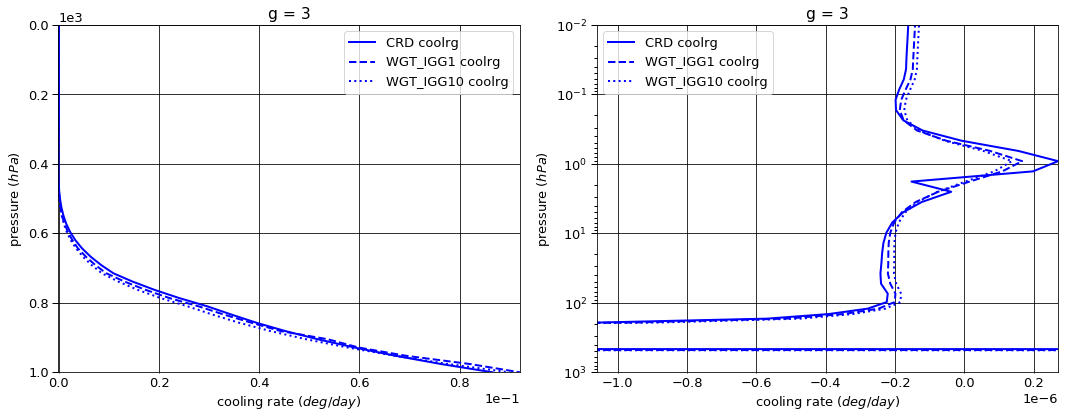

# Figure: cooling rate g-group total

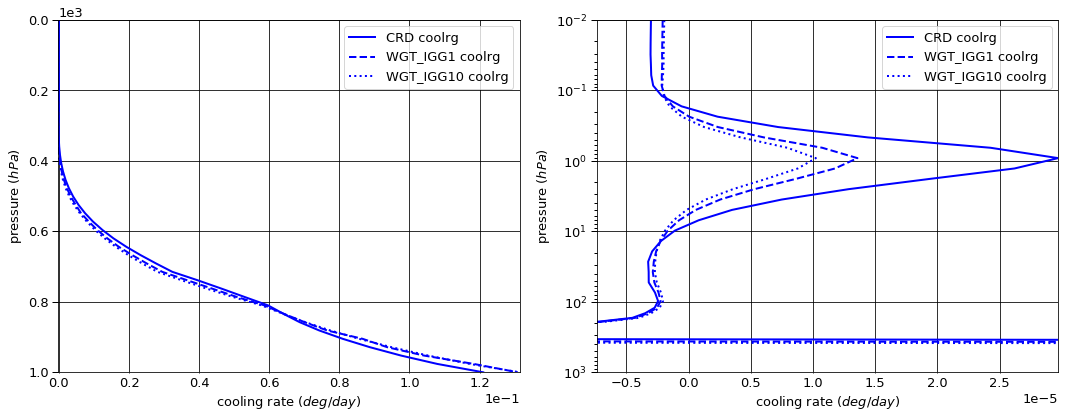

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.149346  0.000000  -0.149346
  1013.0   76     -0.250837  0.246275  -0.004561
2 0.0      1      -1.891532  0.000000  -1.891532
  1013.0   76     -2.249824  1.566274  -0.683550
3 0.0      1     -31.932232  0.000000 -31.932232
  1013.0   76    -32.227981  1.945971 -30.282010


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.148381  0.000000  -0.148381
  1013.0   76     -0.250837  0.247009  -0.003828
2 0.0      1      -1.909141  0.000000  -1.909141
  1013.0   76     -2.249824  1.587896  -0.661929
3 0.0      1     -31.950722  0.000000 -31.950722
  1013.0   76    -32.227981  1.925157 -30.302824


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.147859  0.000000  -0.147859
  1013.0   76     -0.250837  0.247518  -0.003319
2 0.0      1      -1.912611  0.000000  -1.912611
  1013.0   76     -2.249824  1.639857  -0.609968
3 0.0      1     -31.970750  0.000000 -31.970750
  1013.0   76    -32.227981  1.814589 -30.413391


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000964  0.000000  0.000964
  1013.0   76     0.000000  0.000733  0.000733
2 0.0      1     -0.017609  0.000000 -0.017609
  1013.0   76     0.000000  0.021621  0.021621
3 0.0      1     -0.018490  0.000000 -0.018490
  1013.0   76     0.000000 -0.020814 -0.020814


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001487  0.000000  0.001487
  1013.0   76     0.000000  0.001242  0.001242
2 0.0      1     -0.021079  0.000000 -0.021079
  1013.0   76     0.000000  0.073582  0.073582
3 0.0      1     -0.038518  0.000000 -0.038518
  1013.0   76     0.000000 -0.131381 -0.131381

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.377067e-06
  1001.112500 75     1.105825e-03
2 0.000312    1     -1.324616e-06
  1001.112500 75     3.335937e-02
3 0.000312    1     -1.482767e-07
  1001.112500 75     8.659692e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -9.009363e-07
  1001.112500 75     1.091581e-03
2 0.000312    1     -8.981887e-07
  1001.112500 75     3.777765e-02
3 0.000312    1     -1.293998e-07
  1001.112500 75     9.203865e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -8.522714e-07
  1001.112500 75     1.032571e-03
2 0.000312    1     -8.187698e-07
  1001.112500 75     4.052252e-02
3 0.000312    1     -1.189287e-07
  1001.112500 75     8.994520e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.761304e-07
  1001.112500 75    -1.424360e-05
2 0.000312    1      4.264275e-07
  1001.112500 75     4.418276e-03
3 0.000312    1      1.887682e-08
  1001.112500 75     5.441730e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.247953e-07
  1001.112500 75    -7.325390e-05
2 0.000312    1      5.058464e-07
  1001.112500 75     7.163143e-03
3 0.000312    1      2.934793e-08
  1001.112500 75     3.348279e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.973110,0.000000,-33.973110
1013.0,76,-34.728642,3.758521,-30.970121



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.008245,0.000000,-34.008245
1013.0,76,-34.728642,3.760061,-30.968581



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.031220,0.000000,-34.031220
1013.0,76,-34.728642,3.701964,-31.026678



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.035135,0.000000,-0.035135
1013.0,76,0.000000,0.001541,0.001541



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.05811,0.000000,-0.058110
1013.0,76,0.00000,-0.056557,-0.056556


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.121062



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.130908



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.131500



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,9.214346e-07
1001.112500,75,9.845762e-03



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000001
1001.112500,75,0.010438


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007583,0.007049
2,0.065917,0.064206
3,0.926500,0.928744


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.350702e-23
2,1.000478e-24
3,1.361273e-27


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.350702e-23,NaN,0.007583,0.007049,0.007583,0.007049,600.0
2,1.000478e-24,0.074071,0.065917,0.064206,0.073500,0.071256,600.0
3,1.361273e-27,0.001361,0.926500,0.928744,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog       ratio        taulyr
layer g pressure                                                         
1     1 0.000312     1.100883e-23  1.035925e-24   10.627056  4.167091e-10
      2 0.000312     6.700318e-25  2.571674e-26   26.054303  2.629973e-11
      3 0.000312     3.422107e-27  2.041561e-29  167.622060  2.014811e-13
2     1 0.000750     1.113995e-23  1.037864e-24   10.733537  1.696990e-10
      2 0.000750     6.769066e-25  2.578210e-26   26.254911  1.069938e-11
      3 0.000750     3.452964e-27  2.052698e-29  168.215900  8.188537e-14
3     1 0.001052     1.140978e-23  1.041604e-24   10.954050  2.433296e-10
      2 0.001052     6.910435e-25  2.590659e-26   26.674435  1.531075e-11
      3 0.001052     3.516434e-27  2.070578e-29  169.828660  1.169445e-13
4     1 0.001476     1.168925e-23  1.045313e-24   11.182535  3.491289e-10
      2 0.001476     7.056569e-25  2.603404e-26   27.105165  2.192317e-11
      3 0.001476     3.582121e-27  2.089924e-29  171.399560  1.671236e-13
5     1 0.002070     1.197482e-23  1.048955e-24   11.415947  5.008045e-10
      2 0.002070     7.205590e-25  2.616348e-26   27.540646  3.138397e-11
      3 0.002070     3.649197e-27  2.111051e-29  172.861600  2.387925e-13
6     1 0.002904     1.226651e-23  1.052548e-24   11.654111  7.184251e-10
      2 0.002904     7.357500e-25  2.629598e-26   27.979562  4.493124e-11
      3 0.002904     3.717677e-27  2.134636e-29  174.159730  3.412466e-13
7     1 0.004074     1.256442e-23  1.056119e-24   11.896791  1.030599e-09
      2 0.004074     7.512322e-25  2.643313e-26   28.420095  6.432630e-11
      3 0.004074     3.787591e-27  2.161679e-29  175.215260  4.876909e-13
8     1 0.005714     1.286887e-23  1.059707e-24   12.143795  1.478294e-09
      2 0.005714     7.670186e-25  2.657728e-26   28.859932  9.208602e-11
      3 0.005714     3.859020e-27  2.193597e-29  175.922040  6.969723e-13
9     1 0.008015     1.317987e-23  1.063365e-24   12.394493  2.120470e-09
      2 0.008015     7.831065e-25  2.673162e-26   29.295138  1.318257e-10
      3 0.008015     3.931979e-27  2.232360e-29  176.135500  9.961357e-13
10    1 0.011243     1.349770e-23  1.067167e-24   12.648158  3.041537e-09
      2 0.011243     7.995038e-25  2.690078e-26   29.720466  1.887096e-10
      3 0.011243     4.006538e-27  2.280733e-29  175.668850  1.423773e-12
11    1 0.015771     1.382262e-23  1.071218e-24   12.903642  4.362778e-09
      2 0.015771     8.162158e-25  2.709132e-26   30.128313  2.701413e-10
      3 0.015771     4.082766e-27  2.342542e-29  174.287830  2.035165e-12
12    1 0.022122     1.415501e-23  1.075667e-24   13.159291  6.258112e-09
      2 0.022122     8.332509e-25  2.731253e-26   30.508004  3.867108e-10
      3 0.022122     4.160758e-27  2.423052e-29  171.715560  2.909321e-12
13    1 0.031031     1.449651e-23  1.080731e-24   13.413614  8.978081e-09
      2 0.031031     8.506765e-25  2.757795e-26   30.846253  5.536298e-10
      3 0.031031     4.240902e-27  2.529523e-29  167.656210  4.159653e-12
14    1 0.043528     1.494271e-23  1.087474e-24   13.740755  1.295980e-08
      2 0.043528     8.733789e-25  2.794002e-26   31.259064  7.970334e-10
      3 0.043528     4.345702e-27  2.678280e-29  162.257190  5.979171e-12
15    1 0.061057     1.659063e-23  1.104195e-24   15.025083  2.006673e-08
      2 0.061057     9.573803e-25  2.880289e-26   33.239038  1.223681e-09
      3 0.061057     4.734514e-27  2.966886e-29  159.578540  9.137654e-12
16    1 0.085645     2.032562e-23  1.133580e-24   17.930472  3.413577e-08
      2 0.085645     1.146390e-24  3.042730e-26   37.676364  2.049516e-09
      3 0.085645     5.627499e-27  3.512502e-29  160.213410  1.523486e-11
17    1 0.120136     2.562002e-23  1.170946e-24   21.879770  5.977957e-08
      2 0.120136     1.411689e-24  3.266068e-26   43.222898  3.530533e-09
      3 0.120136     6.932096e-27  4.361206e-29  158.949070  2.632448e-11
18    1 0.168516     3.213526e-23  1.219679e-24   26.347316  1.043989e-07
      2 0.168516     1.735581e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
